In [40]:
import pandas as pd

In [41]:
fraud = pd.read_csv('fraud.csv')

In [42]:
fraud.head(5)
fraud.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [43]:
fraud.dropna(how = "any")
fraud.fillna(0)
fraud.nunique()
fraud['type'] = fraud['type'].astype("category")
# I have reduced the memory usage as well as checked for any null values inorder to clean the dataset.


In [44]:
fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype   
---  ------          -----   
 0   step            int64   
 1   type            category
 2   amount          float64 
 3   nameOrig        object  
 4   oldbalanceOrg   float64 
 5   newbalanceOrig  float64 
 6   nameDest        object  
 7   oldbalanceDest  float64 
 8   newbalanceDest  float64 
 9   isFraud         int64   
 10  isFlaggedFraud  int64   
dtypes: category(1), float64(5), int64(3), object(2)
memory usage: 491.5+ MB


In [45]:
fraud.sort_index().head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


In [46]:
fraud[fraud["isFlaggedFraud"] == 1].value_counts()
fraud_counts = fraud["isFraud"].value_counts()
fraud_counts

isFraud
0    6354407
1       8213
Name: count, dtype: int64

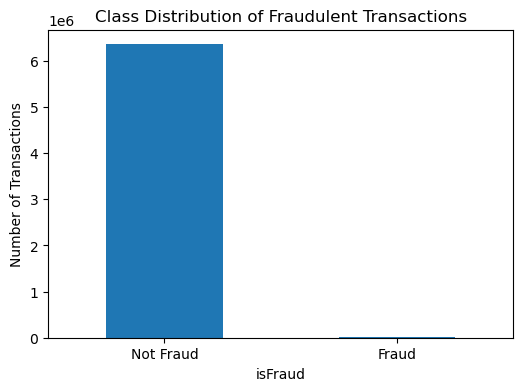

In [47]:
(fraud["isFlaggedFraud"] ==1).value_counts()
# So there are 16 fraudulent transactions that are present in the dataset.
# These may not be the actual Fraudulent transaction.
import matplotlib.pyplot as plt

fraud_counts = fraud["isFraud"].value_counts()

plt.figure(figsize=(6,4))
fraud_counts.plot(kind="bar")
plt.xticks([0,1], ["Not Fraud", "Fraud"], rotation=0)
plt.ylabel("Number of Transactions")
plt.title("Class Distribution of Fraudulent Transactions")
plt.show()

# The dataset is extremely imbalanced, with fraudulent transactions forming a very small fraction of the total data. 
# This confirms that accuracy is not a reliable evaluation metric, as a naive model predicting all transactions as non-fraud would still achieve high accuracy.
# Therefore, recall, precision, and ROC-AUC are more appropriate metrics for this problem.


In [49]:
# Raw balances are highly correlated. Fraud shows up in balance inconsistencies.
fraud["balanceDiffOrig"] = fraud["oldbalanceOrg"] - fraud["newbalanceOrig"]
fraud["balanceDiffDest"] = fraud["newbalanceDest"] - fraud["oldbalanceDest"]
# Flagging risky transaction type

fraud["isTransferOrCashOut"] = fraud["type"].isin(["TRANSFER", "CASH_OUT"]).astype(int)


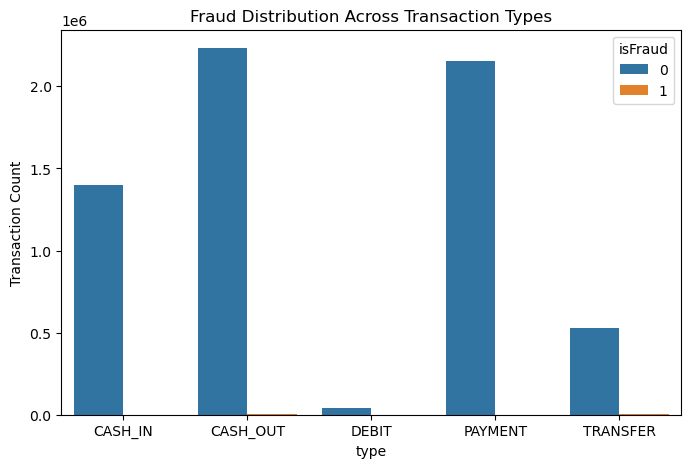

In [50]:
import seaborn as sns

plt.figure(figsize=(8,5))
sns.countplot(data=fraud, x="type", hue="isFraud")
plt.title("Fraud Distribution Across Transaction Types")
plt.ylabel("Transaction Count")
plt.show()

#Fraudulent transactions are overwhelmingly concentrated in TRANSFER and CASH_OUT transaction types, while other transaction types show negligible fraud occurrences.

In [51]:
# Handling skew
import numpy as np
fraud["logAmount"] = np.log1p(fraud["amount"])


# Encoding categorical variable. For this, type must be numeric for ML models.
fraud = pd.get_dummies(fraud, columns=["type"], drop_first=True)




In [14]:
# Drop identifiers and leakage columns
X = fraud.drop([
    "isFraud",
    "isFlaggedFraud",
    "nameOrig",
    "nameDest"
], axis=1)

y = fraud["isFraud"]
# We have to drop isFlaggedFraud as It’s a rule-based outcome
# Including it would cause data leakage

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)





In [18]:
# Baseline Model – Logistic Regression

from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced"
)

log_model.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000)

In [19]:
# Evaluate
from sklearn.metrics import classification_report, roc_auc_score

y_pred_log = log_model.predict(X_test)
y_prob_log = log_model.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred_log))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_log))

# Class weight is balanced as fraud is less than 1% and Forces model to care about minority class.

              precision    recall  f1-score   support

           0       1.00      0.95      0.97   1270881
           1       0.02      0.96      0.04      1643

    accuracy                           0.95   1272524
   macro avg       0.51      0.95      0.51   1272524
weighted avg       1.00      0.95      0.97   1272524

ROC-AUC: 0.9916635173400542


In [20]:

# THE PRIMARY MODEL IS RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=50,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=50, n_jobs=-1, random_state=42)

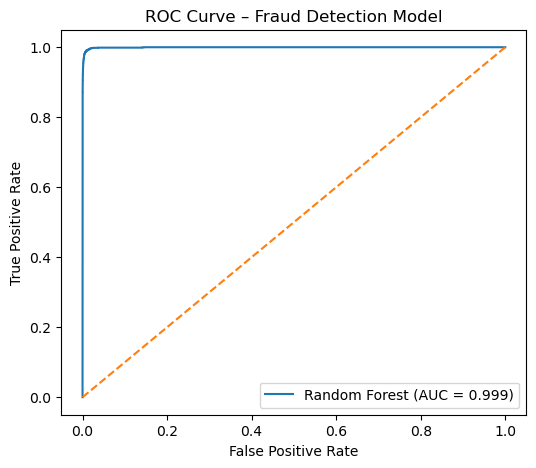

In [54]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_prob_rf)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Fraud Detection Model")
plt.legend()
plt.show()

# ROC Curve (Model Performance)
# The ROC curve shows strong separability between fraudulent and non-fraudulent transactions. 
# The high AUC value indicates that the model effectively ranks risky transactions above legitimate ones, making it suitable for real-time fraud scoring systems.

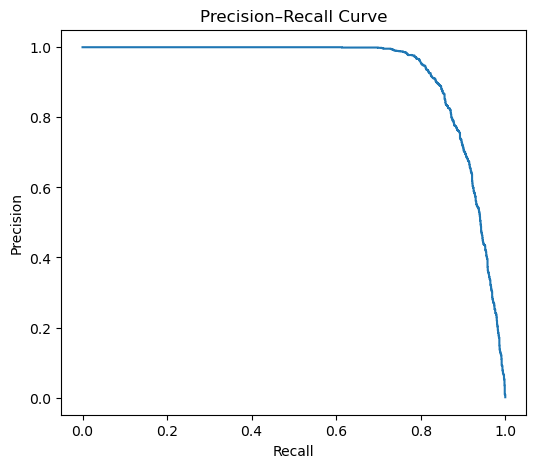

In [56]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, y_prob_rf)

plt.figure(figsize=(6,5))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.show()

# The precision–recall curve highlights the trade-off between identifying fraudulent transactions and minimizing false alarms. 
# In fraud detection, higher recall is prioritized to reduce financial loss, even at the cost of slightly lower precision.

In [21]:
# Evaluate
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))


              precision    recall  f1-score   support

           0       1.00      0.99      0.99   1270881
           1       0.11      0.99      0.20      1643

    accuracy                           0.99   1272524
   macro avg       0.55      0.99      0.60   1272524
weighted avg       1.00      0.99      0.99   1272524

ROC-AUC: 0.9994656327667775


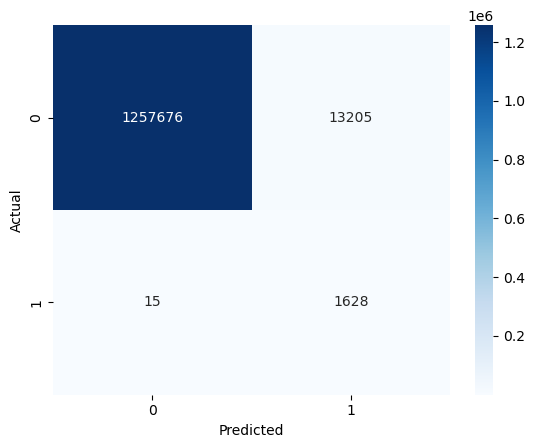

In [22]:
# If we look from the Business View perspective: The confusion matrix is:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_rf)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# The confusion matrix shows that the model successfully captures a large portion of fraudulent transactions (true positives), while maintaining a manageable number of false positives. 
# Since the cost of missing fraud is higher than temporarily flagging a legitimate transaction, this trade-off is acceptable from a business perspective.


In [23]:
# Feature importance:
import pandas as pd

feature_importance = pd.DataFrame({
    "feature": X.columns,
    "importance": rf_model.feature_importances_
}).sort_values(by="importance", ascending=False)

feature_importance.head(10)


,feature,importance
6,balanceDiffOrig,0.317869
8,isTransferOrCashOut,0.119949
2,oldbalanceOrg,0.118583
3,newbalanceOrig,0.082255
9,logAmount,0.064417
1,amount,0.062790
7,balanceDiffDest,0.056519
13,type_TRANSFER,0.047851
5,newbalanceDest,0.033805
0,step,0.031925


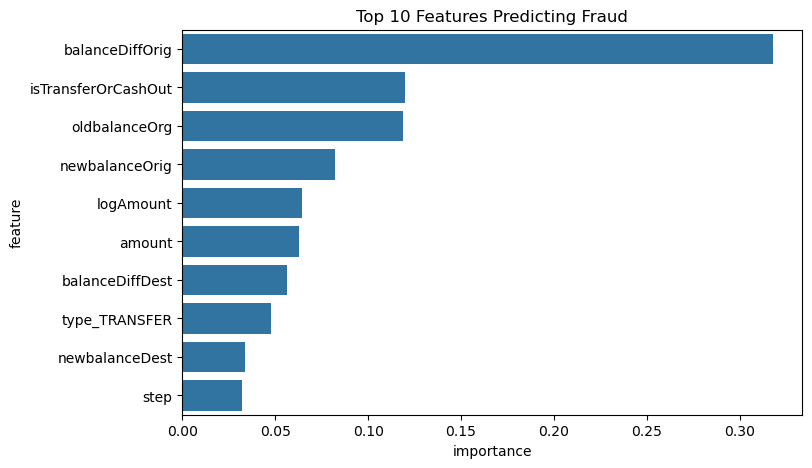

In [58]:
top_features = feature_importance.head(10)

plt.figure(figsize=(8,5))
sns.barplot(data=top_features, x="importance", y="feature")
plt.title("Top 10 Features Predicting Fraud")
plt.show()


In [59]:
# The most influential predictors include transaction amount, balance inconsistencies, and transaction type indicators such as TRANSFER and CASH_OUT. 
# These features align with known fraud mechanisms, where attackers rapidly move large sums and exploit balance mismatches during account takeovers.

In [ ]:
# CONCLUSISON: The model demonstrates that fraud is not random but driven by identifiable behavioral patterns. 
# By combining transaction amount, balance deviations, and transaction type, the model provides both strong predictive performance and interpretable insights.
# These insights can be directly operationalized into real-time monitoring, risk-based authentication, and adaptive transaction controls.